# Lisowski Thesis Fuel Bundle

This notebook is transcribed from Appendix A of the title thesis.  

Lisowski, Eva. Evaluation of material attractiveness to non-state actors of various nuclear materials in Thorium fuel cycles. Massachusetts Institute of Technology, 2020.

In [1]:
from math import pi, sin, cos
import numpy as np
import openmc
import openmc.deplete

In [2]:
fuel_materials = [] # note: list of fuel materials
for i in range(0,35): # had to know in advance how many fuel-containing cells.
    fuel = openmc.Material(name='fuel')
    # 40%LEU-60%Th Oxide fuel. 
    fuel.add_nuclide('Th232',0.60611,'ao')
    fuel.add_nuclide('U235',0.019695,'ao')
    fuel.add_nuclide('U238',0.37420,'ao')
    fuel.add_element('O',2.0)
    fuel.set_density('g/cm3',9.7); # check out Blair Bromley reference
    fuel_materials.append(fuel); 
    # I don't like these numbers, but shift focus on structure of input
    # to get the distributed materials.

# Center displacer rod of ZrO2
center = openmc.Material(name='rod')
center.add_element('Zr',1.0)
center.add_element('O',2.0)
center.set_density('g/cm3',4.3)

# Lisowski approximates Zirc-4 with elemental Zr.
# here I will use the PNNL Material compendium composition for Zirc-4
clad = openmc.Material(name='zircaloy')
clad.add_element('O',0.006790)
clad.add_element('Cr',0.001741)
clad.add_element('Fe',0.003242)
clad.add_element('Zr',0.977550)
clad.add_element('Sn',0.010677)
clad.set_density('g/cm3',6.56)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H2',2.0,'ao')
heavy_water.add_nuclide('O16',1.0,'ao')
heavy_water.add_s_alpha_beta('c_D_in_D2O')
heavy_water.set_density('g/cc',1.1)



In [3]:
# outer radius of fuel and clad
r_fuel_ex = 0.6122 # cm
r_clad_ex = 0.6540 # cm
clad_thickness = r_clad_ex - r_fuel_ex # cm, ignores CO2-filled gap
r_clad = 0.57 # outer radius of Thorium fuel element, given in Bromley paper
r_fuel = r_clad - clad_thickness  #cm. Ah.  I see.  
# use clad thickness from CANDU OpenMC example; apply that to Bromley
# paper example since they do not give clad thickness.

# Outer Radius of the center ZrO2 rod
r_center = 2.4 # cm

# Pressure tube and calendria radii
pressure_tube_ir = 5.2
pressure_tube_or = 5.6
calendria_ir = 6.4
calendria_or = 6.6

ring_radii = np.array([3.0755,4.3305]);

center_radius = np.array([0])

# surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in 
              (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    if i==0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
    water_cells.append(openmc.Cell(fill=heavy_water,region=water_region))



In [4]:
# also create a water region for the center tube
radial_surf_tube = openmc.ZCylinder(r = r_center + clad_thickness)

water_cell_tube = []
water_region_tube = -radial_surf_tube
water_cell_tube.append(openmc.Cell(fill=heavy_water,region=water_region_tube))

plot_args = {'width':(2*calendria_or,2*calendria_or)}
bundle_universe = openmc.Universe(cells=(water_cells))

# pin_cell universe for each fuel pin, divided between inner and outer pins 
# for ease of iteration when creating fuel pins
pin_universes_inner = []
pin_universes_outer = []

fuel_cells = []

for i in range(0,14):
    surf_fuel = openmc.ZCylinder(r=r_fuel)
    fuel_cell = openmc.Cell(fill=fuel_materials[i],region=-surf_fuel)
    clad_cell = openmc.Cell(fill=clad,region=+surf_fuel)
    
    pin_universes_inner.append(openmc.Universe(cells=(fuel_cell,clad_cell)))
    fuel_cells.append(fuel_cell)
    
    
for i in range(14,35):
    surf_fuel = openmc.ZCylinder(r=r_fuel)
    fuel_cell = openmc.Cell(fill=fuel_materials[i],region=-surf_fuel)
    clad_cell = openmc.Cell(fill=clad,region=+surf_fuel)
    
    pin_universes_outer.append(openmc.Universe(cells=(fuel_cell,clad_cell)))
    fuel_cells.append(fuel_cell)
    
# center rod universe
surf_center = openmc.ZCylinder(r=r_center+clad_thickness)
center_cell = openmc.Cell(fill=center,region=-surf_center)
center_tube_cell = openmc.Cell(fill=clad,region=+surf_center)
center_universe = openmc.Universe(cells=(center_cell,center_tube_cell))



In [5]:
# Center tube creation
num_tubes = [1]
angles = [0]

for i, (r,n,a) in enumerate(zip(center_radius,num_tubes,angles)):
    tube_boundary = openmc.ZCylinder(x0=0,y0=0,r=r_center+clad_thickness)
    water_cells[i].region &= +tube_boundary
    tube = openmc.Cell(fill=center_universe,region=-tube_boundary)
    bundle_universe.add_cell(tube)
    
num_pins = [14,21]
angles = [0,0]

for i,(r,n,a) in enumerate(zip(ring_radii, num_pins,angles)):
    for j in range(n):
        theta = (a+j/n*360.)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad)
        water_cells[i].region &= +pin_boundary
        
        if n==14:
            pin=openmc.Cell(fill=pin_universes_inner[j],region=-pin_boundary)
            pin.translation = (x,y,0)
            pin.id = (i+1)*100 + j
            fuel_materials[j].id = pin.id #ID the fuel materials to match the pin ID
        if n == 21:
            pin = openmc.Cell(fill = pin_universes_outer[j],region=-pin_boundary)
            pin.translation = (x,y,0)
            pin.id = (i+1)*100 + j
            fuel_materials[14+j].id = pin.id # ID the fuel materials to match the pin ID
        bundle_universe.add_cell(pin)

In [6]:
#bundle_universe.plot(**plot_args)

In [7]:
pt_inner = openmc.ZCylinder(r=pressure_tube_ir)
pt_outer = openmc.ZCylinder(r=pressure_tube_or)
calendria_inner = openmc.ZCylinder(r=calendria_ir)
calendria_outer = openmc.ZCylinder(r=calendria_or)

bundle = openmc.Cell(fill=bundle_universe,region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad,region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region = +pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

box = openmc.rectangular_prism(width=28.575,height=28.575,boundary_type='reflective')

water_region = box & +calendria_outer
moderator = openmc.Cell(fill=heavy_water, region = water_region)

root_universe = openmc.Universe(cells=[bundle,pressure_tube,v1,calendria,moderator])
geom = openmc.Geometry(root_universe)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values())
mats.export_to_xml()

p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'

p.colors = {
    clad: 'silver',
    center: 'gray',
    heavy_water: 'blue'
}
p.to_ipython_image()

settings = openmc.Settings()
settings.particles = 50000
settings.inactive = 10
settings.batches = 150

settings.source = openmc.Source(space=openmc.stats.Point())
settings.export_to_xml()

In [8]:
#openmc.run() # test to make sure everything works so far.

In [9]:
# Set up depletion material volume
for i in range(0,35):
    fuel_materials[i].volume = r_fuel**2 * pi

# define time step over depletion
time_steps = [0.25, 0.25, 0.25, 0.25, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 
              2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

# for some reason, I now re-define these time_steps
time_steps = [(0.25, 'MWd/kg'), (0.25, 'MWd/kg'), (0.25, 'MWd/kg'), (0.25, 'MWd/kg'), 
             (1.0, 'MWd/kg'), (1.0, 'MWd/kg'), (1.0, 'MWd/kg'), 
             (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), 
             (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), 
             (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), 
             (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), 
             (2.0, 'MWd/kg'), (2.0, 'MWd/kg'), 
             (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), 
             (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), 
             (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), 
             (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd'), (30.0, 'd')]

# define changing power over depletion and cooling
power_bundle = [0.00939e6, 0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 0.00939e6, 0.00939e6, 
               0.00939e6, 0.00939e6, 
               0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 0, 0] # W/cm

chain_file = './chain_casl_pwr.xml'
chain = openmc.deplete.Chain.from_xml(chain_file)

model = openmc.model.Model(geom, mats, settings);
op = openmc.deplete.Operator(model,chain_file)

integrator = openmc.deplete.CECMIntegrator(op,time_steps,power_bundle)

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/

 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5


          1200K
          2500K


 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

       86/1    1.26987    1.27389 +/- 0.00074
       87/1    1.28619    1.27405 +/- 0.00075
       88/1    1.26822    1.27397 +/- 0.00074
       89/1    1.27168    1.27394 +/- 0.00073
       90/1    1.27461    1.27395 +/- 0.00072
       91/1    1.26880    1.27389 +/- 0.00072
       92/1    1.26378    1.27376 +/- 0.00072
       93/1    1.28074    1.27385 +/- 0.00072
       94/1    1.28050    1.27393 +/- 0.00071
       95/1    1.26615    1.27384 +/- 0.00071
       96/1    1.27466    1.27384 +/- 0.00070
       97/1    1.27899    1.27390 +/- 0.00070
       98/1    1.26783    1.27384 +/- 0.00069
       99/1    1.27276    1.27382 +/- 0.00068
      100/1    1.28223    1.27392 +/- 0.00068
      101/1    1.26630    1.27383 +/- 0.00068
      102/1    1.27857    1.27388 +/- 0.00067
      103/1    1.27066    1.27385 +/- 0.00067
      104/1    1.27487    1.27386 +/- 0.00066
      105/1    1.27190    1.27384 +/- 0.00065
      106/1    1.27433    1.27384 +/- 0.00065
      107/1    1.27459    1.27385 

       85/1    1.23272    1.22746 +/- 0.00065
       86/1    1.23239    1.22752 +/- 0.00065
       87/1    1.22470    1.22748 +/- 0.00064
       88/1    1.22303    1.22743 +/- 0.00064
       89/1    1.23450    1.22752 +/- 0.00063
       90/1    1.22522    1.22749 +/- 0.00063
       91/1    1.22236    1.22742 +/- 0.00062
       92/1    1.22865    1.22744 +/- 0.00061
       93/1    1.23508    1.22753 +/- 0.00061
       94/1    1.22297    1.22748 +/- 0.00061
       95/1    1.22716    1.22747 +/- 0.00060
       96/1    1.22501    1.22745 +/- 0.00060
       97/1    1.22518    1.22742 +/- 0.00059
       98/1    1.22396    1.22738 +/- 0.00058
       99/1    1.22878    1.22740 +/- 0.00058
      100/1    1.23000    1.22742 +/- 0.00057
      101/1    1.22099    1.22735 +/- 0.00057
      102/1    1.22467    1.22732 +/- 0.00056
      103/1    1.23816    1.22744 +/- 0.00057
      104/1    1.23292    1.22750 +/- 0.00057
      105/1    1.22446    1.22747 +/- 0.00056
      106/1    1.23312    1.22753 

       85/1    1.21960    1.22085 +/- 0.00077
       86/1    1.22193    1.22086 +/- 0.00076
       87/1    1.22259    1.22088 +/- 0.00075
       88/1    1.21939    1.22087 +/- 0.00074
       89/1    1.21647    1.22081 +/- 0.00074
       90/1    1.23229    1.22095 +/- 0.00074
       91/1    1.22001    1.22094 +/- 0.00073
       92/1    1.20843    1.22079 +/- 0.00074
       93/1    1.22335    1.22082 +/- 0.00073
       94/1    1.22126    1.22083 +/- 0.00072
       95/1    1.21869    1.22080 +/- 0.00071
       96/1    1.22238    1.22082 +/- 0.00071
       97/1    1.22201    1.22083 +/- 0.00070
       98/1    1.22417    1.22087 +/- 0.00069
       99/1    1.21536    1.22081 +/- 0.00069
      100/1    1.20732    1.22066 +/- 0.00070
      101/1    1.22337    1.22069 +/- 0.00069
      102/1    1.21961    1.22068 +/- 0.00068
      103/1    1.23455    1.22083 +/- 0.00069
      104/1    1.21202    1.22073 +/- 0.00069
      105/1    1.22027    1.22073 +/- 0.00068
      106/1    1.22736    1.22080 

       84/1    1.19990    1.21605 +/- 0.00078
       85/1    1.21540    1.21604 +/- 0.00077
       86/1    1.21880    1.21608 +/- 0.00076
       87/1    1.21927    1.21612 +/- 0.00075
       88/1    1.21929    1.21616 +/- 0.00074
       89/1    1.21797    1.21618 +/- 0.00073
       90/1    1.22251    1.21626 +/- 0.00073
       91/1    1.21714    1.21627 +/- 0.00072
       92/1    1.21559    1.21626 +/- 0.00071
       93/1    1.21972    1.21631 +/- 0.00070
       94/1    1.20311    1.21615 +/- 0.00071
       95/1    1.21779    1.21617 +/- 0.00070
       96/1    1.21815    1.21619 +/- 0.00070
       97/1    1.21501    1.21618 +/- 0.00069
       98/1    1.22864    1.21632 +/- 0.00069
       99/1    1.21988    1.21636 +/- 0.00069
      100/1    1.21947    1.21639 +/- 0.00068
      101/1    1.21754    1.21641 +/- 0.00067
      102/1    1.21266    1.21637 +/- 0.00067
      103/1    1.21374    1.21634 +/- 0.00066
      104/1    1.22616    1.21644 +/- 0.00066
      105/1    1.21922    1.21647 

       84/1    1.21167    1.21306 +/- 0.00071
       85/1    1.21279    1.21306 +/- 0.00070
       86/1    1.20894    1.21301 +/- 0.00069
       87/1    1.19898    1.21282 +/- 0.00071
       88/1    1.21637    1.21287 +/- 0.00070
       89/1    1.21030    1.21284 +/- 0.00069
       90/1    1.20433    1.21273 +/- 0.00069
       91/1    1.21661    1.21278 +/- 0.00068
       92/1    1.21119    1.21276 +/- 0.00068
       93/1    1.22406    1.21290 +/- 0.00068
       94/1    1.21280    1.21289 +/- 0.00067
       95/1    1.20060    1.21275 +/- 0.00068
       96/1    1.20724    1.21269 +/- 0.00068
       97/1    1.21346    1.21269 +/- 0.00067
       98/1    1.22377    1.21282 +/- 0.00067
       99/1    1.21754    1.21287 +/- 0.00067
      100/1    1.21458    1.21289 +/- 0.00066
      101/1    1.21614    1.21293 +/- 0.00065
      102/1    1.20495    1.21284 +/- 0.00065
      103/1    1.21056    1.21282 +/- 0.00065
      104/1    1.20684    1.21275 +/- 0.00064
      105/1    1.19906    1.21261 

       83/1    1.20716    1.20956 +/- 0.00072
       84/1    1.20938    1.20956 +/- 0.00071
       85/1    1.20912    1.20956 +/- 0.00070
       86/1    1.21928    1.20968 +/- 0.00070
       87/1    1.20467    1.20962 +/- 0.00069
       88/1    1.21627    1.20970 +/- 0.00069
       89/1    1.20273    1.20962 +/- 0.00069
       90/1    1.21248    1.20965 +/- 0.00068
       91/1    1.20701    1.20962 +/- 0.00067
       92/1    1.20991    1.20962 +/- 0.00066
       93/1    1.20988    1.20963 +/- 0.00066
       94/1    1.21234    1.20966 +/- 0.00065
       95/1    1.21239    1.20969 +/- 0.00064
       96/1    1.20673    1.20966 +/- 0.00063
       97/1    1.21144    1.20968 +/- 0.00063
       98/1    1.20618    1.20964 +/- 0.00062
       99/1    1.21386    1.20968 +/- 0.00062
      100/1    1.20297    1.20961 +/- 0.00061
      101/1    1.19957    1.20950 +/- 0.00062
      102/1    1.20356    1.20943 +/- 0.00061
      103/1    1.20713    1.20941 +/- 0.00061
      104/1    1.21482    1.20947 

       83/1    1.21224    1.20847 +/- 0.00070
       84/1    1.19314    1.20826 +/- 0.00073
       85/1    1.20851    1.20827 +/- 0.00072
       86/1    1.21437    1.20835 +/- 0.00071
       87/1    1.21077    1.20838 +/- 0.00070
       88/1    1.21039    1.20841 +/- 0.00069
       89/1    1.22001    1.20855 +/- 0.00070
       90/1    1.20710    1.20853 +/- 0.00069
       91/1    1.20883    1.20854 +/- 0.00068
       92/1    1.21112    1.20857 +/- 0.00068
       93/1    1.20653    1.20855 +/- 0.00067
       94/1    1.20863    1.20855 +/- 0.00066
       95/1    1.21324    1.20860 +/- 0.00065
       96/1    1.21430    1.20867 +/- 0.00065
       97/1    1.20318    1.20860 +/- 0.00065
       98/1    1.20344    1.20855 +/- 0.00064
       99/1    1.20795    1.20854 +/- 0.00063
      100/1    1.20422    1.20849 +/- 0.00063
      101/1    1.20615    1.20847 +/- 0.00062
      102/1    1.20449    1.20842 +/- 0.00062
      103/1    1.20878    1.20843 +/- 0.00061
      104/1    1.20353    1.20837 

       82/1    1.19436    1.20283 +/- 0.00063
       83/1    1.20112    1.20280 +/- 0.00062
       84/1    1.20119    1.20278 +/- 0.00062
       85/1    1.20600    1.20282 +/- 0.00061
       86/1    1.20605    1.20287 +/- 0.00060
       87/1    1.20944    1.20295 +/- 0.00060
       88/1    1.19703    1.20288 +/- 0.00060
       89/1    1.21297    1.20300 +/- 0.00060
       90/1    1.21160    1.20311 +/- 0.00061
       91/1    1.19910    1.20306 +/- 0.00060
       92/1    1.19633    1.20298 +/- 0.00060
       93/1    1.20935    1.20306 +/- 0.00060
       94/1    1.21139    1.20315 +/- 0.00060
       95/1    1.20283    1.20315 +/- 0.00059
       96/1    1.20877    1.20322 +/- 0.00059
       97/1    1.20643    1.20325 +/- 0.00058
       98/1    1.20583    1.20328 +/- 0.00058
       99/1    1.21058    1.20336 +/- 0.00058
      100/1    1.20393    1.20337 +/- 0.00057
      101/1    1.20953    1.20344 +/- 0.00057
      102/1    1.19844    1.20338 +/- 0.00056
      103/1    1.20721    1.20343 

       82/1    1.18777    1.20098 +/- 0.00082
       83/1    1.19080    1.20084 +/- 0.00082
       84/1    1.19685    1.20079 +/- 0.00081
       85/1    1.20276    1.20081 +/- 0.00080
       86/1    1.19576    1.20075 +/- 0.00079
       87/1    1.19140    1.20062 +/- 0.00079
       88/1    1.20030    1.20062 +/- 0.00078
       89/1    1.19747    1.20058 +/- 0.00077
       90/1    1.20423    1.20063 +/- 0.00076
       91/1    1.21392    1.20079 +/- 0.00077
       92/1    1.19727    1.20075 +/- 0.00076
       93/1    1.18990    1.20062 +/- 0.00077
       94/1    1.20610    1.20068 +/- 0.00076
       95/1    1.20860    1.20078 +/- 0.00076
       96/1    1.20435    1.20082 +/- 0.00075
       97/1    1.20529    1.20087 +/- 0.00074
       98/1    1.20547    1.20092 +/- 0.00074
       99/1    1.19504    1.20085 +/- 0.00073
      100/1    1.20709    1.20092 +/- 0.00073
      101/1    1.20690    1.20099 +/- 0.00072
      102/1    1.20658    1.20105 +/- 0.00071
      103/1    1.19738    1.20101 

       81/1    1.19646    1.19295 +/- 0.00061
       82/1    1.19493    1.19298 +/- 0.00060
       83/1    1.19192    1.19296 +/- 0.00059
       84/1    1.18924    1.19291 +/- 0.00059
       85/1    1.19632    1.19296 +/- 0.00058
       86/1    1.19962    1.19305 +/- 0.00058
       87/1    1.18931    1.19300 +/- 0.00057
       88/1    1.19370    1.19301 +/- 0.00057
       89/1    1.19635    1.19305 +/- 0.00056
       90/1    1.19013    1.19301 +/- 0.00056
       91/1    1.19424    1.19303 +/- 0.00055
       92/1    1.19242    1.19302 +/- 0.00054
       93/1    1.19611    1.19306 +/- 0.00054
       94/1    1.18507    1.19296 +/- 0.00054
       95/1    1.19507    1.19299 +/- 0.00053
       96/1    1.19176    1.19297 +/- 0.00053
       97/1    1.19198    1.19296 +/- 0.00052
       98/1    1.19251    1.19296 +/- 0.00052
       99/1    1.19013    1.19293 +/- 0.00051
      100/1    1.20131    1.19302 +/- 0.00051
      101/1    1.19426    1.19303 +/- 0.00051
      102/1    1.19261    1.19303 

       81/1    1.18626    1.18521 +/- 0.00064
       82/1    1.18896    1.18526 +/- 0.00063
       83/1    1.19206    1.18535 +/- 0.00063
       84/1    1.18748    1.18538 +/- 0.00062
       85/1    1.17939    1.18530 +/- 0.00062
       86/1    1.18540    1.18530 +/- 0.00061
       87/1    1.18257    1.18527 +/- 0.00061
       88/1    1.18179    1.18522 +/- 0.00060
       89/1    1.17964    1.18515 +/- 0.00060
       90/1    1.17713    1.18505 +/- 0.00060
       91/1    1.19128    1.18513 +/- 0.00059
       92/1    1.18225    1.18509 +/- 0.00059
       93/1    1.18163    1.18505 +/- 0.00058
       94/1    1.18080    1.18500 +/- 0.00058
       95/1    1.18914    1.18505 +/- 0.00057
       96/1    1.18439    1.18504 +/- 0.00057
       97/1    1.18615    1.18506 +/- 0.00056
       98/1    1.17869    1.18498 +/- 0.00056
       99/1    1.18031    1.18493 +/- 0.00055
      100/1    1.16989    1.18476 +/- 0.00057
      101/1    1.18616    1.18478 +/- 0.00057
      102/1    1.18727    1.18481 

       80/1    1.18192    1.17774 +/- 0.00072
       81/1    1.16934    1.17762 +/- 0.00072
       82/1    1.18186    1.17768 +/- 0.00072
       83/1    1.17345    1.17762 +/- 0.00071
       84/1    1.17704    1.17762 +/- 0.00070
       85/1    1.18089    1.17766 +/- 0.00069
       86/1    1.16632    1.17751 +/- 0.00070
       87/1    1.17590    1.17749 +/- 0.00069
       88/1    1.17572    1.17747 +/- 0.00068
       89/1    1.19314    1.17767 +/- 0.00070
       90/1    1.16574    1.17752 +/- 0.00071
       91/1    1.17648    1.17750 +/- 0.00070
       92/1    1.18583    1.17760 +/- 0.00070
       93/1    1.18274    1.17767 +/- 0.00069
       94/1    1.17940    1.17769 +/- 0.00068
       95/1    1.17400    1.17764 +/- 0.00068
       96/1    1.17806    1.17765 +/- 0.00067
       97/1    1.17399    1.17761 +/- 0.00066
       98/1    1.17129    1.17753 +/- 0.00066
       99/1    1.17785    1.17754 +/- 0.00065
      100/1    1.17416    1.17750 +/- 0.00065
      101/1    1.17876    1.17751 

       80/1    1.17272    1.16985 +/- 0.00072
       81/1    1.17088    1.16987 +/- 0.00071
       82/1    1.16756    1.16984 +/- 0.00070
       83/1    1.16794    1.16981 +/- 0.00070
       84/1    1.17371    1.16986 +/- 0.00069
       85/1    1.17844    1.16998 +/- 0.00069
       86/1    1.16486    1.16991 +/- 0.00068
       87/1    1.17808    1.17002 +/- 0.00068
       88/1    1.16710    1.16998 +/- 0.00067
       89/1    1.17146    1.17000 +/- 0.00067
       90/1    1.16421    1.16993 +/- 0.00066
       91/1    1.17541    1.16999 +/- 0.00066
       92/1    1.16603    1.16995 +/- 0.00065
       93/1    1.17516    1.17001 +/- 0.00065
       94/1    1.16682    1.16997 +/- 0.00064
       95/1    1.17471    1.17003 +/- 0.00063
       96/1    1.16758    1.17000 +/- 0.00063
       97/1    1.17239    1.17002 +/- 0.00062
       98/1    1.17397    1.17007 +/- 0.00062
       99/1    1.15816    1.16994 +/- 0.00062
      100/1    1.16570    1.16989 +/- 0.00062
      101/1    1.16071    1.16979 

       79/1    1.15974    1.16439 +/- 0.00071
       80/1    1.15323    1.16423 +/- 0.00072
       81/1    1.16576    1.16426 +/- 0.00071
       82/1    1.16874    1.16432 +/- 0.00070
       83/1    1.16461    1.16432 +/- 0.00069
       84/1    1.15932    1.16425 +/- 0.00069
       85/1    1.15847    1.16418 +/- 0.00068
       86/1    1.16306    1.16416 +/- 0.00067
       87/1    1.16576    1.16418 +/- 0.00067
       88/1    1.16664    1.16421 +/- 0.00066
       89/1    1.16490    1.16422 +/- 0.00065
       90/1    1.16792    1.16427 +/- 0.00064
       91/1    1.15776    1.16419 +/- 0.00064
       92/1    1.16718    1.16423 +/- 0.00063
       93/1    1.16290    1.16421 +/- 0.00063
       94/1    1.16107    1.16417 +/- 0.00062
       95/1    1.16442    1.16418 +/- 0.00061
       96/1    1.15903    1.16412 +/- 0.00061
       97/1    1.16476    1.16412 +/- 0.00060
       98/1    1.15154    1.16398 +/- 0.00061
       99/1    1.16175    1.16395 +/- 0.00060
      100/1    1.16888    1.16401 

       79/1    1.15626    1.15693 +/- 0.00072
       80/1    1.15050    1.15684 +/- 0.00071
       81/1    1.15622    1.15683 +/- 0.00070
       82/1    1.15725    1.15683 +/- 0.00069
       83/1    1.15840    1.15686 +/- 0.00068
       84/1    1.15447    1.15682 +/- 0.00068
       85/1    1.15826    1.15684 +/- 0.00067
       86/1    1.15201    1.15678 +/- 0.00066
       87/1    1.14836    1.15667 +/- 0.00066
       88/1    1.15184    1.15661 +/- 0.00066
       89/1    1.16027    1.15665 +/- 0.00065
       90/1    1.16899    1.15681 +/- 0.00066
       91/1    1.15191    1.15675 +/- 0.00065
       92/1    1.15431    1.15672 +/- 0.00065
       93/1    1.16471    1.15681 +/- 0.00065
       94/1    1.15922    1.15684 +/- 0.00064
       95/1    1.15928    1.15687 +/- 0.00063
       96/1    1.16091    1.15692 +/- 0.00063
       97/1    1.14503    1.15678 +/- 0.00063
       98/1    1.15687    1.15678 +/- 0.00063
       99/1    1.14960    1.15670 +/- 0.00062
      100/1    1.15033    1.15663 

       78/1    1.14143    1.14444 +/- 0.00063
       79/1    1.15561    1.14460 +/- 0.00064
       80/1    1.14772    1.14464 +/- 0.00063
       81/1    1.15556    1.14480 +/- 0.00064
       82/1    1.14223    1.14476 +/- 0.00063
       83/1    1.14874    1.14482 +/- 0.00063
       84/1    1.15408    1.14494 +/- 0.00063
       85/1    1.13891    1.14486 +/- 0.00063
       86/1    1.14480    1.14486 +/- 0.00062
       87/1    1.15318    1.14497 +/- 0.00062
       88/1    1.13781    1.14488 +/- 0.00062
       89/1    1.15369    1.14499 +/- 0.00062
       90/1    1.13370    1.14485 +/- 0.00063
       91/1    1.14606    1.14486 +/- 0.00062
       92/1    1.14434    1.14486 +/- 0.00062
       93/1    1.15290    1.14495 +/- 0.00062
       94/1    1.14587    1.14496 +/- 0.00061
       95/1    1.14636    1.14498 +/- 0.00060
       96/1    1.13856    1.14490 +/- 0.00060
       97/1    1.14198    1.14487 +/- 0.00059
       98/1    1.14243    1.14484 +/- 0.00059
       99/1    1.15114    1.14491 

       78/1    1.14114    1.13254 +/- 0.00074
       79/1    1.13075    1.13252 +/- 0.00073
       80/1    1.12731    1.13244 +/- 0.00073
       81/1    1.13408    1.13247 +/- 0.00072
       82/1    1.13712    1.13253 +/- 0.00071
       83/1    1.13078    1.13251 +/- 0.00070
       84/1    1.12139    1.13236 +/- 0.00071
       85/1    1.13367    1.13237 +/- 0.00070
       86/1    1.13881    1.13246 +/- 0.00069
       87/1    1.13793    1.13253 +/- 0.00069
       88/1    1.14864    1.13274 +/- 0.00071
       89/1    1.13060    1.13271 +/- 0.00070
       90/1    1.13908    1.13279 +/- 0.00070
       91/1    1.14142    1.13290 +/- 0.00070
       92/1    1.12826    1.13284 +/- 0.00069
       93/1    1.13313    1.13284 +/- 0.00068
       94/1    1.13490    1.13287 +/- 0.00067
       95/1    1.13585    1.13290 +/- 0.00067
       96/1    1.12742    1.13284 +/- 0.00066
       97/1    1.13473    1.13286 +/- 0.00065
       98/1    1.13588    1.13289 +/- 0.00065
       99/1    1.13076    1.13287 

       77/1    1.11932    1.12037 +/- 0.00069
       78/1    1.11943    1.12035 +/- 0.00068
       79/1    1.11273    1.12024 +/- 0.00068
       80/1    1.12569    1.12032 +/- 0.00067
       81/1    1.11215    1.12020 +/- 0.00067
       82/1    1.12022    1.12020 +/- 0.00066
       83/1    1.11007    1.12007 +/- 0.00067
       84/1    1.11218    1.11996 +/- 0.00067
       85/1    1.11558    1.11990 +/- 0.00066
       86/1    1.11989    1.11990 +/- 0.00065
       87/1    1.12495    1.11997 +/- 0.00065
       88/1    1.11955    1.11996 +/- 0.00064
       89/1    1.11569    1.11991 +/- 0.00063
       90/1    1.12596    1.11998 +/- 0.00063
       91/1    1.11659    1.11994 +/- 0.00062
       92/1    1.11600    1.11989 +/- 0.00062
       93/1    1.11522    1.11984 +/- 0.00061
       94/1    1.12268    1.11987 +/- 0.00061
       95/1    1.11194    1.11978 +/- 0.00061
       96/1    1.11723    1.11975 +/- 0.00060
       97/1    1.12912    1.11985 +/- 0.00060
       98/1    1.12392    1.11990 

       77/1    1.10808    1.10872 +/- 0.00066
       78/1    1.10776    1.10871 +/- 0.00065
       79/1    1.09995    1.10858 +/- 0.00065
       80/1    1.10446    1.10852 +/- 0.00065
       81/1    1.10503    1.10848 +/- 0.00064
       82/1    1.10732    1.10846 +/- 0.00063
       83/1    1.11004    1.10848 +/- 0.00062
       84/1    1.11200    1.10853 +/- 0.00062
       85/1    1.10507    1.10848 +/- 0.00061
       86/1    1.10951    1.10850 +/- 0.00060
       87/1    1.11231    1.10855 +/- 0.00060
       88/1    1.10755    1.10853 +/- 0.00059
       89/1    1.10413    1.10848 +/- 0.00058
       90/1    1.11479    1.10856 +/- 0.00058
       91/1    1.10545    1.10852 +/- 0.00058
       92/1    1.10581    1.10848 +/- 0.00057
       93/1    1.11013    1.10850 +/- 0.00056
       94/1    1.11068    1.10853 +/- 0.00056
       95/1    1.10558    1.10850 +/- 0.00055
       96/1    1.10770    1.10849 +/- 0.00054
       97/1    1.11182    1.10852 +/- 0.00054
       98/1    1.11226    1.10857 

       76/1    1.10330    1.09725 +/- 0.00063
       77/1    1.09833    1.09727 +/- 0.00062
       78/1    1.09044    1.09717 +/- 0.00062
       79/1    1.10040    1.09721 +/- 0.00061
       80/1    1.09460    1.09718 +/- 0.00060
       81/1    1.09022    1.09708 +/- 0.00060
       82/1    1.09966    1.09712 +/- 0.00060
       83/1    1.10068    1.09716 +/- 0.00059
       84/1    1.09725    1.09717 +/- 0.00058
       85/1    1.10270    1.09724 +/- 0.00058
       86/1    1.09843    1.09725 +/- 0.00057
       87/1    1.09521    1.09723 +/- 0.00056
       88/1    1.10453    1.09732 +/- 0.00056
       89/1    1.10602    1.09743 +/- 0.00057
       90/1    1.09912    1.09745 +/- 0.00056
       91/1    1.09406    1.09741 +/- 0.00056
       92/1    1.09828    1.09742 +/- 0.00055
       93/1    1.08910    1.09732 +/- 0.00055
       94/1    1.09597    1.09731 +/- 0.00055
       95/1    1.09938    1.09733 +/- 0.00054
       96/1    1.09340    1.09728 +/- 0.00053
       97/1    1.10007    1.09732 

       76/1    1.09125    1.08558 +/- 0.00060
       77/1    1.08306    1.08555 +/- 0.00059
       78/1    1.08572    1.08555 +/- 0.00058
       79/1    1.08852    1.08559 +/- 0.00058
       80/1    1.07381    1.08542 +/- 0.00059
       81/1    1.08691    1.08544 +/- 0.00059
       82/1    1.08151    1.08539 +/- 0.00058
       83/1    1.08686    1.08541 +/- 0.00057
       84/1    1.08545    1.08541 +/- 0.00056
       85/1    1.09052    1.08548 +/- 0.00056
       86/1    1.08046    1.08541 +/- 0.00056
       87/1    1.08835    1.08545 +/- 0.00055
       88/1    1.08314    1.08542 +/- 0.00055
       89/1    1.08890    1.08546 +/- 0.00054
       90/1    1.08787    1.08549 +/- 0.00053
       91/1    1.08493    1.08549 +/- 0.00053
       92/1    1.07800    1.08540 +/- 0.00053
       93/1    1.08354    1.08537 +/- 0.00052
       94/1    1.08050    1.08532 +/- 0.00052
       95/1    1.08173    1.08527 +/- 0.00052
       96/1    1.10408    1.08549 +/- 0.00055
       97/1    1.08264    1.08546 

       75/1    1.06919    1.07352 +/- 0.00065
       76/1    1.07320    1.07351 +/- 0.00064
       77/1    1.06425    1.07338 +/- 0.00065
       78/1    1.06843    1.07330 +/- 0.00064
       79/1    1.07091    1.07327 +/- 0.00063
       80/1    1.06715    1.07318 +/- 0.00063
       81/1    1.07906    1.07326 +/- 0.00063
       82/1    1.07419    1.07328 +/- 0.00062
       83/1    1.07972    1.07337 +/- 0.00062
       84/1    1.06994    1.07332 +/- 0.00061
       85/1    1.07648    1.07336 +/- 0.00060
       86/1    1.07128    1.07333 +/- 0.00060
       87/1    1.07037    1.07330 +/- 0.00059
       88/1    1.07520    1.07332 +/- 0.00058
       89/1    1.07587    1.07335 +/- 0.00058
       90/1    1.08137    1.07345 +/- 0.00058
       91/1    1.07440    1.07346 +/- 0.00057
       92/1    1.07501    1.07348 +/- 0.00056
       93/1    1.07630    1.07352 +/- 0.00056
       94/1    1.07443    1.07353 +/- 0.00055
       95/1    1.07291    1.07352 +/- 0.00054
       96/1    1.07651    1.07356 

       75/1    1.06452    1.06240 +/- 0.00072
       76/1    1.05875    1.06234 +/- 0.00071
       77/1    1.07704    1.06256 +/- 0.00073
       78/1    1.06231    1.06256 +/- 0.00072
       79/1    1.06647    1.06262 +/- 0.00071
       80/1    1.06004    1.06258 +/- 0.00070
       81/1    1.06907    1.06267 +/- 0.00070
       82/1    1.05980    1.06263 +/- 0.00069
       83/1    1.06265    1.06263 +/- 0.00068
       84/1    1.05877    1.06258 +/- 0.00067
       85/1    1.05759    1.06251 +/- 0.00067
       86/1    1.06153    1.06250 +/- 0.00066
       87/1    1.05722    1.06243 +/- 0.00065
       88/1    1.06820    1.06251 +/- 0.00065
       89/1    1.05462    1.06241 +/- 0.00065
       90/1    1.06069    1.06238 +/- 0.00064
       91/1    1.07653    1.06256 +/- 0.00066
       92/1    1.06304    1.06257 +/- 0.00065
       93/1    1.07311    1.06269 +/- 0.00065
       94/1    1.05791    1.06264 +/- 0.00065
       95/1    1.06756    1.06269 +/- 0.00064
       96/1    1.06453    1.06271 

       74/1    1.05061    1.05057 +/- 0.00063
       75/1    1.04682    1.05051 +/- 0.00062
       76/1    1.04010    1.05035 +/- 0.00063
       77/1    1.05760    1.05046 +/- 0.00063
       78/1    1.05393    1.05051 +/- 0.00062
       79/1    1.04945    1.05050 +/- 0.00061
       80/1    1.05670    1.05059 +/- 0.00061
       81/1    1.05607    1.05066 +/- 0.00061
       82/1    1.04764    1.05062 +/- 0.00060
       83/1    1.05246    1.05065 +/- 0.00059
       84/1    1.04525    1.05057 +/- 0.00059
       85/1    1.05762    1.05067 +/- 0.00059
       86/1    1.04969    1.05066 +/- 0.00058
       87/1    1.05086    1.05066 +/- 0.00057
       88/1    1.04831    1.05063 +/- 0.00057
       89/1    1.04878    1.05061 +/- 0.00056
       90/1    1.04843    1.05058 +/- 0.00055
       91/1    1.04152    1.05047 +/- 0.00056
       92/1    1.05089    1.05047 +/- 0.00055
       93/1    1.04502    1.05041 +/- 0.00055
       94/1    1.04636    1.05036 +/- 0.00054
       95/1    1.03770    1.05021 

       74/1    1.03716    1.04017 +/- 0.00068
       75/1    1.05106    1.04034 +/- 0.00069
       76/1    1.04218    1.04036 +/- 0.00068
       77/1    1.03403    1.04027 +/- 0.00068
       78/1    1.04392    1.04032 +/- 0.00067
       79/1    1.04604    1.04041 +/- 0.00066
       80/1    1.04385    1.04046 +/- 0.00066
       81/1    1.03546    1.04038 +/- 0.00065
       82/1    1.03622    1.04033 +/- 0.00064
       83/1    1.03699    1.04028 +/- 0.00064
       84/1    1.03924    1.04027 +/- 0.00063
       85/1    1.03989    1.04026 +/- 0.00062
       86/1    1.04143    1.04028 +/- 0.00061
       87/1    1.05282    1.04044 +/- 0.00063
       88/1    1.03683    1.04039 +/- 0.00062
       89/1    1.03653    1.04035 +/- 0.00061
       90/1    1.04052    1.04035 +/- 0.00061
       91/1    1.03283    1.04025 +/- 0.00061
       92/1    1.04174    1.04027 +/- 0.00060
       93/1    1.03279    1.04018 +/- 0.00060
       94/1    1.03562    1.04013 +/- 0.00059
       95/1    1.04564    1.04019 

       73/1    1.02920    1.02995 +/- 0.00067
       74/1    1.02305    1.02984 +/- 0.00067
       75/1    1.03365    1.02990 +/- 0.00066
       76/1    1.04408    1.03011 +/- 0.00069
       77/1    1.03453    1.03018 +/- 0.00068
       78/1    1.03194    1.03020 +/- 0.00067
       79/1    1.02384    1.03011 +/- 0.00067
       80/1    1.02840    1.03009 +/- 0.00066
       81/1    1.03662    1.03018 +/- 0.00065
       82/1    1.03050    1.03018 +/- 0.00064
       83/1    1.02116    1.03006 +/- 0.00065
       84/1    1.02228    1.02996 +/- 0.00065
       85/1    1.02736    1.02992 +/- 0.00064
       86/1    1.02639    1.02987 +/- 0.00063
       87/1    1.02817    1.02985 +/- 0.00062
       88/1    1.02978    1.02985 +/- 0.00062
       89/1    1.03119    1.02987 +/- 0.00061
       90/1    1.02688    1.02983 +/- 0.00060
       91/1    1.03470    1.02989 +/- 0.00060
       92/1    1.02820    1.02987 +/- 0.00059
       93/1    1.03299    1.02991 +/- 0.00059
       94/1    1.02897    1.02990 

       73/1    1.02715    1.02025 +/- 0.00070
       74/1    1.01525    1.02017 +/- 0.00070
       75/1    1.02652    1.02027 +/- 0.00069
       76/1    1.01411    1.02018 +/- 0.00069
       77/1    1.02222    1.02021 +/- 0.00068
       78/1    1.01926    1.02019 +/- 0.00067
       79/1    1.02357    1.02024 +/- 0.00066
       80/1    1.01680    1.02019 +/- 0.00065
       81/1    1.02253    1.02023 +/- 0.00065
       82/1    1.02339    1.02027 +/- 0.00064
       83/1    1.01856    1.02025 +/- 0.00063
       84/1    1.01607    1.02019 +/- 0.00062
       85/1    1.01059    1.02006 +/- 0.00063
       86/1    1.01975    1.02006 +/- 0.00062
       87/1    1.01840    1.02004 +/- 0.00061
       88/1    1.02578    1.02011 +/- 0.00061
       89/1    1.02377    1.02016 +/- 0.00060
       90/1    1.01708    1.02012 +/- 0.00060
       91/1    1.02608    1.02019 +/- 0.00059
       92/1    1.01960    1.02018 +/- 0.00059
       93/1    1.02420    1.02023 +/- 0.00058
       94/1    1.02351    1.02027 

       72/1    1.01955    1.01166 +/- 0.00065
       73/1    1.01292    1.01168 +/- 0.00064
       74/1    1.01317    1.01170 +/- 0.00063
       75/1    1.00891    1.01166 +/- 0.00062
       76/1    1.00849    1.01161 +/- 0.00061
       77/1    1.01336    1.01163 +/- 0.00060
       78/1    1.01583    1.01170 +/- 0.00060
       79/1    1.02193    1.01184 +/- 0.00061
       80/1    1.02007    1.01196 +/- 0.00061
       81/1    1.01278    1.01197 +/- 0.00060
       82/1    1.01098    1.01196 +/- 0.00059
       83/1    1.01330    1.01198 +/- 0.00058
       84/1    1.01243    1.01198 +/- 0.00058
       85/1    1.01700    1.01205 +/- 0.00057
       86/1    1.01433    1.01208 +/- 0.00057
       87/1    1.01222    1.01208 +/- 0.00056
       88/1    1.00414    1.01198 +/- 0.00056
       89/1    1.00460    1.01189 +/- 0.00056
       90/1    1.01159    1.01188 +/- 0.00055
       91/1    1.01131    1.01188 +/- 0.00055
       92/1    1.00687    1.01182 +/- 0.00054
       93/1    1.01502    1.01185 

       72/1    1.00644    1.00097 +/- 0.00055
       73/1    0.99921    1.00094 +/- 0.00055
       74/1    1.00491    1.00101 +/- 0.00054
       75/1    1.00212    1.00102 +/- 0.00053
       76/1    1.00322    1.00106 +/- 0.00053
       77/1    1.00873    1.00117 +/- 0.00053
       78/1    0.99956    1.00115 +/- 0.00052
       79/1    0.99431    1.00105 +/- 0.00053
       80/1    1.00628    1.00112 +/- 0.00052
       81/1    0.99825    1.00108 +/- 0.00052
       82/1    1.00565    1.00115 +/- 0.00051
       83/1    1.00005    1.00113 +/- 0.00051
       84/1    1.00666    1.00121 +/- 0.00051
       85/1    1.00640    1.00127 +/- 0.00050
       86/1    1.00292    1.00130 +/- 0.00050
       87/1    1.00312    1.00132 +/- 0.00049
       88/1    1.00696    1.00139 +/- 0.00049
       89/1    1.00110    1.00139 +/- 0.00048
       90/1    1.00835    1.00148 +/- 0.00049
       91/1    0.99696    1.00142 +/- 0.00048
       92/1    1.00339    1.00144 +/- 0.00048
       93/1    1.00032    1.00143 

       71/1    0.99424    0.99324 +/- 0.00075
       72/1    0.99714    0.99331 +/- 0.00074
       73/1    0.99836    0.99339 +/- 0.00073
       74/1    0.98762    0.99330 +/- 0.00073
       75/1    0.97573    0.99303 +/- 0.00076
       76/1    0.99671    0.99308 +/- 0.00075
       77/1    0.99375    0.99309 +/- 0.00074
       78/1    0.98846    0.99302 +/- 0.00073
       79/1    0.99464    0.99305 +/- 0.00072
       80/1    0.99695    0.99310 +/- 0.00072
       81/1    1.00175    0.99323 +/- 0.00072
       82/1    0.99327    0.99323 +/- 0.00071
       83/1    0.98785    0.99315 +/- 0.00070
       84/1    0.99368    0.99316 +/- 0.00069
       85/1    0.98504    0.99305 +/- 0.00069
       86/1    0.99280    0.99305 +/- 0.00068
       87/1    0.99159    0.99303 +/- 0.00067
       88/1    0.98257    0.99290 +/- 0.00068
       89/1    0.99329    0.99290 +/- 0.00067
       90/1    0.99040    0.99287 +/- 0.00066
       91/1    0.99825    0.99294 +/- 0.00066
       92/1    0.98661    0.99286 

       71/1    0.97947    0.98570 +/- 0.00054
       72/1    0.99178    0.98580 +/- 0.00054
       73/1    0.98193    0.98574 +/- 0.00053
       74/1    0.98626    0.98575 +/- 0.00053
       75/1    0.99717    0.98592 +/- 0.00055
       76/1    0.98773    0.98595 +/- 0.00054
       77/1    0.98735    0.98597 +/- 0.00053
       78/1    0.99420    0.98609 +/- 0.00054
       79/1    0.98152    0.98602 +/- 0.00053
       80/1    0.99310    0.98613 +/- 0.00054
       81/1    0.97832    0.98602 +/- 0.00054
       82/1    0.98286    0.98597 +/- 0.00053
       83/1    0.98961    0.98602 +/- 0.00053
       84/1    0.98991    0.98607 +/- 0.00052
       85/1    0.97735    0.98596 +/- 0.00053
       86/1    0.98811    0.98599 +/- 0.00052
       87/1    0.99010    0.98604 +/- 0.00052
       88/1    0.98149    0.98598 +/- 0.00052
       89/1    0.98489    0.98597 +/- 0.00051
       90/1    0.98263    0.98593 +/- 0.00050
       91/1    0.98214    0.98588 +/- 0.00050
       92/1    0.99181    0.98595 

       70/1    0.98053    0.97883 +/- 0.00066
       71/1    0.97802    0.97881 +/- 0.00065
       72/1    0.97953    0.97882 +/- 0.00064
       73/1    0.98298    0.97889 +/- 0.00063
       74/1    0.97619    0.97885 +/- 0.00062
       75/1    0.98496    0.97894 +/- 0.00062
       76/1    0.97443    0.97887 +/- 0.00061
       77/1    0.97465    0.97881 +/- 0.00061
       78/1    0.97866    0.97881 +/- 0.00060
       79/1    0.97758    0.97879 +/- 0.00059
       80/1    0.97116    0.97868 +/- 0.00059
       81/1    0.96975    0.97856 +/- 0.00060
       82/1    0.97993    0.97857 +/- 0.00059
       83/1    0.97635    0.97854 +/- 0.00058
       84/1    0.97700    0.97852 +/- 0.00057
       85/1    0.97830    0.97852 +/- 0.00057
       86/1    0.97715    0.97850 +/- 0.00056
       87/1    0.98473    0.97858 +/- 0.00056
       88/1    0.97794    0.97857 +/- 0.00055
       89/1    0.97752    0.97856 +/- 0.00054
       90/1    0.98200    0.97860 +/- 0.00054
       91/1    0.98089    0.97863 

       70/1    0.97051    0.97139 +/- 0.00066
       71/1    0.96827    0.97134 +/- 0.00065
       72/1    0.96460    0.97123 +/- 0.00065
       73/1    0.96193    0.97108 +/- 0.00065
       74/1    0.96776    0.97103 +/- 0.00065
       75/1    0.98298    0.97121 +/- 0.00066
       76/1    0.97671    0.97130 +/- 0.00066
       77/1    0.97155    0.97130 +/- 0.00065
       78/1    0.97053    0.97129 +/- 0.00064
       79/1    0.96898    0.97126 +/- 0.00063
       80/1    0.96256    0.97113 +/- 0.00063
       81/1    0.97872    0.97124 +/- 0.00063
       82/1    0.95917    0.97107 +/- 0.00065
       83/1    0.97293    0.97110 +/- 0.00064
       84/1    0.96681    0.97104 +/- 0.00063
       85/1    0.96964    0.97102 +/- 0.00062
       86/1    0.97569    0.97108 +/- 0.00062
       87/1    0.96885    0.97105 +/- 0.00061
       88/1    0.97105    0.97105 +/- 0.00060
       89/1    0.97712    0.97113 +/- 0.00060
       90/1    0.96890    0.97110 +/- 0.00059
       91/1    0.96755    0.97106 

       69/1    0.96333    0.96448 +/- 0.00063
       70/1    0.95838    0.96438 +/- 0.00063
       71/1    0.96503    0.96439 +/- 0.00062
       72/1    0.95720    0.96427 +/- 0.00062
       73/1    0.96851    0.96434 +/- 0.00062
       74/1    0.96518    0.96435 +/- 0.00061
       75/1    0.95683    0.96423 +/- 0.00061
       76/1    0.96535    0.96425 +/- 0.00060
       77/1    0.96534    0.96427 +/- 0.00059
       78/1    0.96711    0.96431 +/- 0.00058
       79/1    0.96783    0.96436 +/- 0.00058
       80/1    0.97217    0.96447 +/- 0.00058
       81/1    0.96549    0.96449 +/- 0.00057
       82/1    0.97435    0.96462 +/- 0.00058
       83/1    0.96358    0.96461 +/- 0.00057
       84/1    0.96332    0.96459 +/- 0.00056
       85/1    0.95981    0.96453 +/- 0.00056
       86/1    0.96125    0.96448 +/- 0.00055
       87/1    0.96851    0.96454 +/- 0.00055
       88/1    0.96486    0.96454 +/- 0.00054
       89/1    0.97230    0.96464 +/- 0.00054
       90/1    0.96500    0.96464 

       69/1    0.95868    0.95929 +/- 0.00056
       70/1    0.95600    0.95923 +/- 0.00056
       71/1    0.96007    0.95925 +/- 0.00055
       72/1    0.95997    0.95926 +/- 0.00054
       73/1    0.95496    0.95919 +/- 0.00054
       74/1    0.94953    0.95904 +/- 0.00055
       75/1    0.96287    0.95910 +/- 0.00054
       76/1    0.96415    0.95918 +/- 0.00054
       77/1    0.96023    0.95919 +/- 0.00053
       78/1    0.94859    0.95904 +/- 0.00055
       79/1    0.96955    0.95919 +/- 0.00056
       80/1    0.95487    0.95913 +/- 0.00056
       81/1    0.96076    0.95915 +/- 0.00055
       82/1    0.95969    0.95916 +/- 0.00054
       83/1    0.95666    0.95912 +/- 0.00053
       84/1    0.95260    0.95903 +/- 0.00053
       85/1    0.95603    0.95899 +/- 0.00053
       86/1    0.95646    0.95896 +/- 0.00052
       87/1    0.95775    0.95894 +/- 0.00052
       88/1    0.96622    0.95904 +/- 0.00052
       89/1    0.96025    0.95905 +/- 0.00051
       90/1    0.95092    0.95895 

       68/1    0.95812    0.95252 +/- 0.00055
       69/1    0.95119    0.95250 +/- 0.00054
       70/1    0.94891    0.95244 +/- 0.00053
       71/1    0.95401    0.95246 +/- 0.00053
       72/1    0.94815    0.95239 +/- 0.00052
       73/1    0.95152    0.95238 +/- 0.00051
       74/1    0.95630    0.95244 +/- 0.00051
       75/1    0.95862    0.95254 +/- 0.00051
       76/1    0.95117    0.95251 +/- 0.00050
       77/1    0.95367    0.95253 +/- 0.00050
       78/1    0.95255    0.95253 +/- 0.00049
       79/1    0.95188    0.95252 +/- 0.00048
       80/1    0.94772    0.95245 +/- 0.00048
       81/1    0.94823    0.95239 +/- 0.00048
       82/1    0.94228    0.95225 +/- 0.00049
       83/1    0.95717    0.95232 +/- 0.00049
       84/1    0.95091    0.95230 +/- 0.00048
       85/1    0.94956    0.95227 +/- 0.00048
       86/1    0.95260    0.95227 +/- 0.00047
       87/1    0.94932    0.95223 +/- 0.00047
       88/1    0.95156    0.95222 +/- 0.00046
       89/1    0.94986    0.95219 

       68/1    0.95075    0.94818 +/- 0.00064
       69/1    0.95338    0.94827 +/- 0.00063
       70/1    0.95070    0.94831 +/- 0.00062
       71/1    0.94770    0.94830 +/- 0.00061
       72/1    0.95379    0.94839 +/- 0.00061
       73/1    0.95842    0.94855 +/- 0.00062
       74/1    0.95108    0.94859 +/- 0.00061
       75/1    0.93995    0.94846 +/- 0.00062
       76/1    0.95204    0.94851 +/- 0.00061
       77/1    0.94791    0.94850 +/- 0.00060
       78/1    0.94640    0.94847 +/- 0.00059
       79/1    0.94422    0.94841 +/- 0.00059
       80/1    0.94646    0.94838 +/- 0.00058
       81/1    0.95209    0.94843 +/- 0.00057
       82/1    0.94666    0.94841 +/- 0.00057
       83/1    0.95184    0.94846 +/- 0.00056
       84/1    0.93903    0.94833 +/- 0.00057
       85/1    0.94775    0.94832 +/- 0.00056
       86/1    0.94544    0.94828 +/- 0.00055
       87/1    0.93987    0.94817 +/- 0.00056
       88/1    0.94678    0.94816 +/- 0.00055
       89/1    0.94375    0.94810 

       67/1    0.94516    0.94246 +/- 0.00061
       68/1    0.93712    0.94237 +/- 0.00060
       69/1    0.94356    0.94239 +/- 0.00059
       70/1    0.94331    0.94240 +/- 0.00058
       71/1    0.94826    0.94250 +/- 0.00058
       72/1    0.94137    0.94248 +/- 0.00057
       73/1    0.94101    0.94246 +/- 0.00056
       74/1    0.94057    0.94243 +/- 0.00056
       75/1    0.94222    0.94242 +/- 0.00055
       76/1    0.94543    0.94247 +/- 0.00054
       77/1    0.94711    0.94254 +/- 0.00054
       78/1    0.94326    0.94255 +/- 0.00053
       79/1    0.94113    0.94253 +/- 0.00052
       80/1    0.94579    0.94257 +/- 0.00052
       81/1    0.94715    0.94264 +/- 0.00051
       82/1    0.94000    0.94260 +/- 0.00051
       83/1    0.94085    0.94258 +/- 0.00050
       84/1    0.94343    0.94259 +/- 0.00049
       85/1    0.93633    0.94251 +/- 0.00049
       86/1    0.94487    0.94254 +/- 0.00049
       87/1    0.94221    0.94253 +/- 0.00048
       88/1    0.94636    0.94258 

       67/1    0.93163    0.93742 +/- 0.00058
       68/1    0.94295    0.93752 +/- 0.00057
       69/1    0.94381    0.93762 +/- 0.00058
       70/1    0.93777    0.93763 +/- 0.00057
       71/1    0.93616    0.93760 +/- 0.00056
       72/1    0.93863    0.93762 +/- 0.00055
       73/1    0.94847    0.93779 +/- 0.00057
       74/1    0.93481    0.93774 +/- 0.00056
       75/1    0.93706    0.93773 +/- 0.00055
       76/1    0.93627    0.93771 +/- 0.00054
       77/1    0.93609    0.93769 +/- 0.00053
       78/1    0.94046    0.93773 +/- 0.00053
       79/1    0.94419    0.93782 +/- 0.00053
       80/1    0.94161    0.93788 +/- 0.00052
       81/1    0.93770    0.93787 +/- 0.00052
       82/1    0.94275    0.93794 +/- 0.00051
       83/1    0.93219    0.93786 +/- 0.00051
       84/1    0.93929    0.93788 +/- 0.00051
       85/1    0.94331    0.93795 +/- 0.00050
       86/1    0.93216    0.93788 +/- 0.00050
       87/1    0.93224    0.93780 +/- 0.00050
       88/1    0.94046    0.93784 

       66/1    0.93703    0.93213 +/- 0.00048
       67/1    0.92731    0.93205 +/- 0.00048
       68/1    0.93623    0.93212 +/- 0.00048
       69/1    0.92774    0.93204 +/- 0.00048
       70/1    0.92721    0.93196 +/- 0.00048
       71/1    0.93709    0.93205 +/- 0.00048
       72/1    0.94290    0.93222 +/- 0.00050
       73/1    0.92592    0.93212 +/- 0.00050
       74/1    0.93127    0.93211 +/- 0.00049
       75/1    0.92099    0.93194 +/- 0.00052
       76/1    0.93054    0.93192 +/- 0.00051
       77/1    0.94166    0.93206 +/- 0.00052
       78/1    0.93081    0.93204 +/- 0.00051
       79/1    0.92556    0.93195 +/- 0.00051
       80/1    0.92914    0.93191 +/- 0.00051
       81/1    0.93809    0.93200 +/- 0.00051
       82/1    0.93044    0.93198 +/- 0.00050
       83/1    0.94102    0.93210 +/- 0.00051
       84/1    0.93130    0.93209 +/- 0.00050
       85/1    0.93080    0.93207 +/- 0.00050
       86/1    0.93448    0.93210 +/- 0.00049
       87/1    0.93143    0.93209 

       66/1    0.92354    0.92879 +/- 0.00064
       67/1    0.92973    0.92881 +/- 0.00063
       68/1    0.92772    0.92879 +/- 0.00061
       69/1    0.93601    0.92891 +/- 0.00062
       70/1    0.92306    0.92881 +/- 0.00061
       71/1    0.92957    0.92883 +/- 0.00060
       72/1    0.93234    0.92888 +/- 0.00060
       73/1    0.92348    0.92880 +/- 0.00059
       74/1    0.92208    0.92869 +/- 0.00059
       75/1    0.92441    0.92863 +/- 0.00059
       76/1    0.93178    0.92867 +/- 0.00058
       77/1    0.92721    0.92865 +/- 0.00057
       78/1    0.92436    0.92859 +/- 0.00057
       79/1    0.92895    0.92859 +/- 0.00056
       80/1    0.92716    0.92857 +/- 0.00055
       81/1    0.93643    0.92868 +/- 0.00056
       82/1    0.92498    0.92863 +/- 0.00055
       83/1    0.92926    0.92864 +/- 0.00054
       84/1    0.92270    0.92856 +/- 0.00054
       85/1    0.92553    0.92852 +/- 0.00054
       86/1    0.92592    0.92849 +/- 0.00053
       87/1    0.93448    0.92856 

       65/1    0.93103    0.92620 +/- 0.00065
       66/1    0.92480    0.92617 +/- 0.00064
       67/1    0.93035    0.92624 +/- 0.00063
       68/1    0.92203    0.92617 +/- 0.00062
       69/1    0.92228    0.92611 +/- 0.00062
       70/1    0.92893    0.92615 +/- 0.00061
       71/1    0.91861    0.92603 +/- 0.00061
       72/1    0.92746    0.92605 +/- 0.00060
       73/1    0.93445    0.92619 +/- 0.00061
       74/1    0.92865    0.92622 +/- 0.00060
       75/1    0.92916    0.92627 +/- 0.00059
       76/1    0.92866    0.92631 +/- 0.00058
       77/1    0.93397    0.92642 +/- 0.00059
       78/1    0.92673    0.92642 +/- 0.00058
       79/1    0.93163    0.92650 +/- 0.00057
       80/1    0.92887    0.92653 +/- 0.00057
       81/1    0.92431    0.92650 +/- 0.00056
       82/1    0.92655    0.92650 +/- 0.00055
       83/1    0.92543    0.92649 +/- 0.00054
       84/1    0.93123    0.92655 +/- 0.00054
       85/1    0.92018    0.92647 +/- 0.00054
       86/1    0.92845    0.92649 

       65/1    0.91749    0.92318 +/- 0.00069
       66/1    0.91801    0.92308 +/- 0.00069
       67/1    0.90954    0.92285 +/- 0.00072
       68/1    0.91555    0.92272 +/- 0.00072
       69/1    0.91381    0.92257 +/- 0.00072
       70/1    0.92036    0.92253 +/- 0.00071
       71/1    0.92122    0.92251 +/- 0.00070
       72/1    0.92319    0.92252 +/- 0.00069
       73/1    0.92331    0.92253 +/- 0.00067
       74/1    0.91877    0.92248 +/- 0.00067
       75/1    0.92012    0.92244 +/- 0.00066
       76/1    0.92257    0.92244 +/- 0.00065
       77/1    0.91486    0.92233 +/- 0.00065
       78/1    0.92789    0.92241 +/- 0.00064
       79/1    0.91680    0.92233 +/- 0.00064
       80/1    0.92211    0.92233 +/- 0.00063
       81/1    0.92174    0.92232 +/- 0.00062
       82/1    0.92466    0.92235 +/- 0.00061
       83/1    0.91624    0.92227 +/- 0.00061
       84/1    0.92703    0.92233 +/- 0.00061
       85/1    0.91883    0.92228 +/- 0.00060
       86/1    0.92898    0.92237 

       64/1    0.91364    0.92047 +/- 0.00063
       65/1    0.92202    0.92050 +/- 0.00061
       66/1    0.91653    0.92043 +/- 0.00061
       67/1    0.92285    0.92047 +/- 0.00060
       68/1    0.91884    0.92044 +/- 0.00059
       69/1    0.91746    0.92039 +/- 0.00058
       70/1    0.92107    0.92040 +/- 0.00057
       71/1    0.91674    0.92034 +/- 0.00056
       72/1    0.92300    0.92039 +/- 0.00056
       73/1    0.93084    0.92055 +/- 0.00057
       74/1    0.90686    0.92034 +/- 0.00060
       75/1    0.91561    0.92027 +/- 0.00060
       76/1    0.92324    0.92031 +/- 0.00059
       77/1    0.92298    0.92035 +/- 0.00058
       78/1    0.92503    0.92042 +/- 0.00058
       79/1    0.91193    0.92030 +/- 0.00058
       80/1    0.91492    0.92022 +/- 0.00058
       81/1    0.92441    0.92028 +/- 0.00057
       82/1    0.92097    0.92029 +/- 0.00057
       83/1    0.91989    0.92028 +/- 0.00056
       84/1    0.91727    0.92024 +/- 0.00055
       85/1    0.92329    0.92028 

       64/1    0.91006    0.91725 +/- 0.00061
       65/1    0.91744    0.91725 +/- 0.00060
       66/1    0.91450    0.91720 +/- 0.00059
       67/1    0.92243    0.91729 +/- 0.00059
       68/1    0.93434    0.91759 +/- 0.00065
       69/1    0.91499    0.91754 +/- 0.00064
       70/1    0.91808    0.91755 +/- 0.00063
       71/1    0.91407    0.91749 +/- 0.00062
       72/1    0.92407    0.91760 +/- 0.00062
       73/1    0.92370    0.91770 +/- 0.00062
       74/1    0.92559    0.91782 +/- 0.00062
       75/1    0.91567    0.91779 +/- 0.00061
       76/1    0.91706    0.91778 +/- 0.00060
       77/1    0.92887    0.91794 +/- 0.00062
       78/1    0.91309    0.91787 +/- 0.00061
       79/1    0.91478    0.91783 +/- 0.00061
       80/1    0.91860    0.91784 +/- 0.00060
       81/1    0.92146    0.91789 +/- 0.00059
       82/1    0.92255    0.91795 +/- 0.00059
       83/1    0.91208    0.91787 +/- 0.00058
       84/1    0.91161    0.91779 +/- 0.00058
       85/1    0.91792    0.91779 

       63/1    0.91841    0.91345 +/- 0.00065
       64/1    0.91053    0.91339 +/- 0.00064
       65/1    0.91227    0.91337 +/- 0.00063
       66/1    0.91062    0.91332 +/- 0.00062
       67/1    0.91009    0.91327 +/- 0.00061
       68/1    0.90701    0.91316 +/- 0.00061
       69/1    0.91401    0.91317 +/- 0.00060
       70/1    0.92022    0.91329 +/- 0.00060
       71/1    0.91253    0.91328 +/- 0.00059
       72/1    0.91489    0.91330 +/- 0.00058
       73/1    0.91574    0.91334 +/- 0.00057
       74/1    0.91700    0.91340 +/- 0.00057
       75/1    0.91636    0.91345 +/- 0.00056
       76/1    0.91203    0.91342 +/- 0.00055
       77/1    0.91820    0.91349 +/- 0.00055
       78/1    0.91590    0.91353 +/- 0.00054
       79/1    0.91098    0.91349 +/- 0.00053
       80/1    0.90772    0.91341 +/- 0.00053
       81/1    0.91538    0.91344 +/- 0.00053
       82/1    0.91174    0.91341 +/- 0.00052
       83/1    0.91433    0.91343 +/- 0.00051
       84/1    0.91500    0.91345 

       63/1    0.90120    0.91179 +/- 0.00063
       64/1    0.91426    0.91184 +/- 0.00062
       65/1    0.91032    0.91181 +/- 0.00061
       66/1    0.90993    0.91178 +/- 0.00060
       67/1    0.90908    0.91173 +/- 0.00059
       68/1    0.90597    0.91163 +/- 0.00058
       69/1    0.91712    0.91173 +/- 0.00058
       70/1    0.91339    0.91175 +/- 0.00057
       71/1    0.90629    0.91166 +/- 0.00057
       72/1    0.90131    0.91150 +/- 0.00059
       73/1    0.90702    0.91143 +/- 0.00058
       74/1    0.91630    0.91150 +/- 0.00058
       75/1    0.91782    0.91160 +/- 0.00058
       76/1    0.91998    0.91173 +/- 0.00058
       77/1    0.90820    0.91167 +/- 0.00058
       78/1    0.91446    0.91171 +/- 0.00057
       79/1    0.91066    0.91170 +/- 0.00056
       80/1    0.91652    0.91177 +/- 0.00056
       81/1    0.91222    0.91177 +/- 0.00055
       82/1    0.91643    0.91184 +/- 0.00054
       83/1    0.90904    0.91180 +/- 0.00054
       84/1    0.91276    0.91181 

       62/1    0.91219    0.90864 +/- 0.00070
       63/1    0.90488    0.90857 +/- 0.00069
       64/1    0.90859    0.90857 +/- 0.00067
       65/1    0.91090    0.90861 +/- 0.00066
       66/1    0.91024    0.90864 +/- 0.00065
       67/1    0.91576    0.90876 +/- 0.00065
       68/1    0.91225    0.90882 +/- 0.00064
       69/1    0.91016    0.90885 +/- 0.00063
       70/1    0.91038    0.90887 +/- 0.00062
       71/1    0.91381    0.90895 +/- 0.00062
       72/1    0.90910    0.90896 +/- 0.00061
       73/1    0.91488    0.90905 +/- 0.00061
       74/1    0.90646    0.90901 +/- 0.00060
       75/1    0.90507    0.90895 +/- 0.00059
       76/1    0.90519    0.90889 +/- 0.00059
       77/1    0.91292    0.90895 +/- 0.00058
       78/1    0.91168    0.90899 +/- 0.00057
       79/1    0.90706    0.90896 +/- 0.00057
       80/1    0.91079    0.90899 +/- 0.00056
       81/1    0.91046    0.90901 +/- 0.00055
       82/1    0.91022    0.90903 +/- 0.00054
       83/1    0.91143    0.90906 

       62/1    0.90872    0.90710 +/- 0.00060
       63/1    0.91285    0.90721 +/- 0.00060
       64/1    0.90847    0.90723 +/- 0.00059
       65/1    0.90068    0.90711 +/- 0.00059
       66/1    0.90895    0.90714 +/- 0.00058
       67/1    0.91258    0.90724 +/- 0.00058
       68/1    0.92025    0.90746 +/- 0.00061
       69/1    0.91017    0.90751 +/- 0.00060
       70/1    0.90654    0.90749 +/- 0.00059
       71/1    0.90592    0.90747 +/- 0.00058
       72/1    0.90613    0.90745 +/- 0.00057
       73/1    0.90612    0.90743 +/- 0.00056
       74/1    0.90191    0.90734 +/- 0.00056
       75/1    0.90763    0.90734 +/- 0.00055
       76/1    0.90640    0.90733 +/- 0.00054
       77/1    0.90278    0.90726 +/- 0.00054
       78/1    0.90541    0.90723 +/- 0.00053
       79/1    0.90344    0.90718 +/- 0.00053
       80/1    0.90113    0.90709 +/- 0.00053
       81/1    0.89913    0.90698 +/- 0.00053
       82/1    0.91089    0.90704 +/- 0.00053
       83/1    0.90905    0.90706 

       61/1    0.91510    0.90546 +/- 0.00071
       62/1    0.90489    0.90544 +/- 0.00070
       63/1    0.90156    0.90537 +/- 0.00069
       64/1    0.90544    0.90537 +/- 0.00068
       65/1    0.90629    0.90539 +/- 0.00066
       66/1    0.90421    0.90537 +/- 0.00065
       67/1    0.90203    0.90531 +/- 0.00064
       68/1    0.91068    0.90540 +/- 0.00064
       69/1    0.90182    0.90534 +/- 0.00063
       70/1    0.91619    0.90552 +/- 0.00065
       71/1    0.90061    0.90544 +/- 0.00064
       72/1    0.90924    0.90550 +/- 0.00063
       73/1    0.91132    0.90560 +/- 0.00063
       74/1    0.90975    0.90566 +/- 0.00062
       75/1    0.90481    0.90565 +/- 0.00061
       76/1    0.90377    0.90562 +/- 0.00060
       77/1    0.90353    0.90559 +/- 0.00060
       78/1    0.90636    0.90560 +/- 0.00059
       79/1    0.90162    0.90554 +/- 0.00058
       80/1    0.90691    0.90556 +/- 0.00057
       81/1    0.90887    0.90561 +/- 0.00057
       82/1    0.90441    0.90559 

In [10]:
type(fuel_materials[1])

openmc.material.Material

In [11]:
print(fuel_materials[2].volume)

0.8764893963705208


In [13]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')
time,k = results.get_eigenvalue()





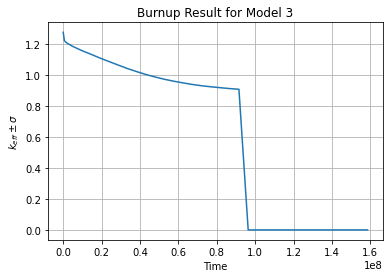

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Model 3')
plt.xlabel('Time')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()